<a href="https://colab.research.google.com/github/ghadfield32/Deep_learning/blob/main/02multiClassificationPytorchModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


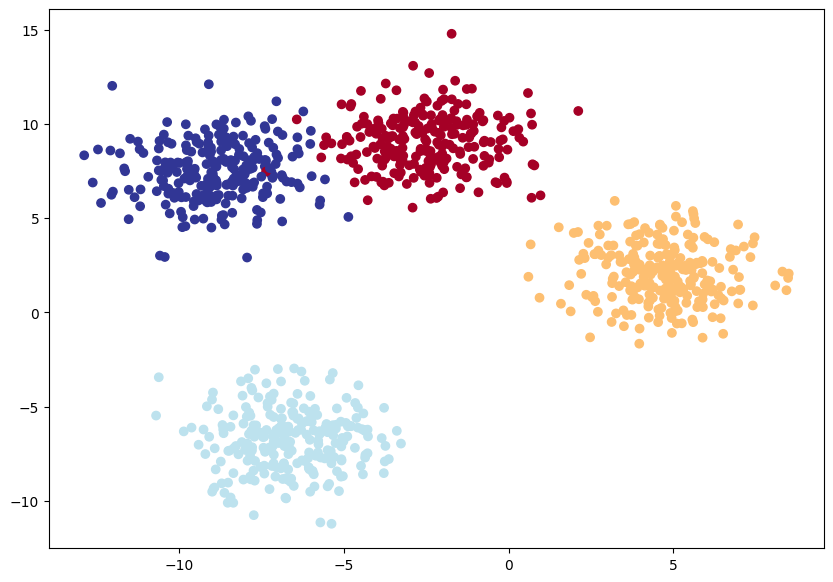

In [ ]:
#**Import Packages and Set up Multi Class Dataset
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X, y = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)
print(X[:5], y[:5])

# 3. Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
    y,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [ ]:
#**Set up Torch device formula
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
from torch import nn

# **Build model: three Linear Layers and an ReLU to handle Non-Linear data
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
             nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
#Creating a loss function and optimizer for a multi-class PyTorch model
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.1) # try changing the learning rate here and seeing what happens to the model's performance

In [ ]:
#The softmax function calculates the probability of each prediction class being the actual predicted class compared to all other possible classes.

# **Make prediction logits with model
y_logits = model_4(X_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) #use sigmoid instead of softmax
print(y_logits[:5])
print(y_pred_probs[:5])
# Sum the first sample output of the softmax activation function, should add to 1 or close to
torch.sum(y_pred_probs[0])

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc


tensor([[-1.2464, -0.8990, -1.4913, -0.5871],
        [ 0.8125, -1.6255,  0.7427,  1.9673],
        [ 0.2863, -0.3251,  0.2584,  0.0986],
        [-0.7877, -0.5911, -0.9520, -0.4658],
        [-0.4386, -1.8562, -0.5667,  1.0392]], grad_fn=<SliceBackward0>)
tensor([[0.1949, 0.2758, 0.1525, 0.3768],
        [0.1926, 0.0168, 0.1796, 0.6111],
        [0.2990, 0.1623, 0.2908, 0.2479],
        [0.2250, 0.2738, 0.1909, 0.3104],
        [0.1537, 0.0372, 0.1352, 0.6738]], grad_fn=<SliceBackward0>)


In [ ]:
#Creating a training and testing loop for a multi-class PyTorch model

# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 1.18218, Acc: 29.50% | Test Loss: 0.92226, Test Acc: 70.00%
Epoch: 10 | Loss: 0.48415, Acc: 96.75% | Test Loss: 0.48694, Test Acc: 97.50%
Epoch: 20 | Loss: 0.33571, Acc: 99.00% | Test Loss: 0.34120, Test Acc: 99.50%
Epoch: 30 | Loss: 0.25764, Acc: 99.00% | Test Loss: 0.25995, Test Acc: 99.50%
Epoch: 40 | Loss: 0.18760, Acc: 99.00% | Test Loss: 0.18233, Test Acc: 99.50%
Epoch: 50 | Loss: 0.10798, Acc: 99.00% | Test Loss: 0.09815, Test Acc: 99.50%
Epoch: 60 | Loss: 0.06487, Acc: 99.12% | Test Loss: 0.05628, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04906, Acc: 99.25% | Test Loss: 0.04078, Test Acc: 99.50%
Epoch: 80 | Loss: 0.04183, Acc: 99.12% | Test Loss: 0.03347, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03775, Acc: 99.12% | Test Loss: 0.02922, Test Acc: 99.50%


In [ ]:
#Making and evaluating predictions with a PyTorch multi-class model

# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_test)

# View the first 10 predictions
y_logits[:10]


tensor([[  2.9849,   9.1582,  -9.3079, -12.6296],
        [  2.8329,  -8.9875,   2.0465,   8.4220],
        [ -2.0086,  -4.2221,   4.5588,  -0.1115],
        [  0.8716,   6.1868,  -4.9749,  -8.4562],
        [  6.6117,   1.7516,  -8.3380,  -4.8122],
        [  3.1911, -10.7773,   2.4867,  10.1428],
        [ -1.9692,  -3.8132,   4.1783,   0.1711],
        [  5.8630,  -1.0438,  -5.4178,  -0.7326],
        [ -2.4899,  -5.3520,   5.5467,  -0.1460],
        [  6.0587,  -0.2768,  -6.1471,  -2.0405]])

In [ ]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


helper_functions.py already exists, skipping download


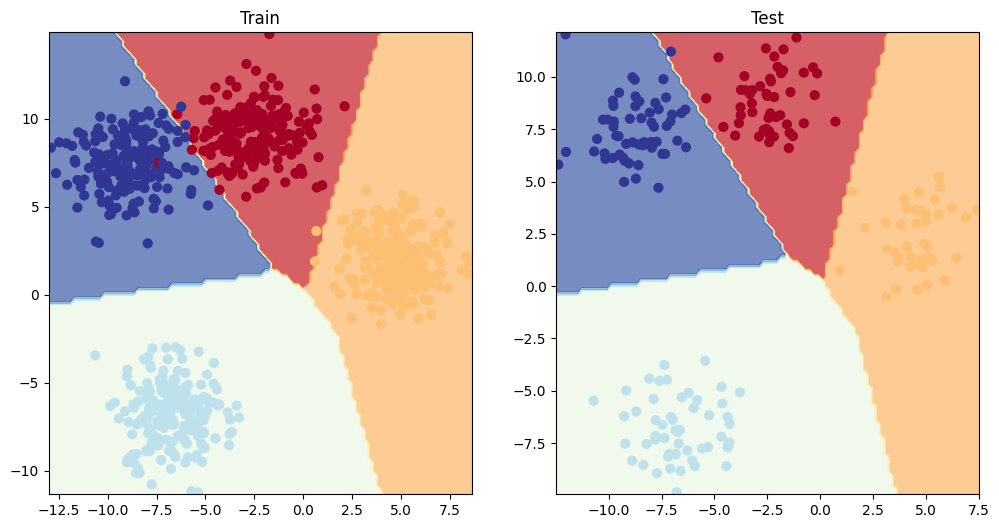

In [ ]:
#Let's visualize them with plot_decision_boundary()
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_test, y_test)

In [ ]:

from torchmetrics import Accuracy, Precision, Recall, F1Score, AUROC

# Ensure target device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize metrics
accuracy_metric = Accuracy(num_classes=NUM_CLASSES).to(device)
precision_metric = Precision(num_classes=NUM_CLASSES, average='macro').to(device) # use 'binary' if it's strictly binary classification
recall_metric = Recall(num_classes=NUM_CLASSES, average='macro').to(device)       # use 'binary' if it's strictly binary classification
f1_metric = F1Score(num_classes=NUM_CLASSES, average='macro').to(device)               # use 'binary' if it's strictly binary classification
#auroc_metric = AUROC(num_classes=NUM_CLASSES).to(device)

# Assuming y_preds and y_test are tensors and on the same device (CUDA or CPU)

# Calculate metrics
accuracy = accuracy_metric(y_preds, y_test)
precision = precision_metric(y_preds, y_test)
recall = recall_metric(y_preds, y_test)
f1 = f1_metric(y_preds, y_test)
#auroc = auroc_metric(y_preds, y_test)

# Print the metrics
print(f"Accuracy: {accuracy.item():.4f}")
print(f"Precision: {precision.item():.4f}")
print(f"Recall: {recall.item():.4f}")
print(f"F1 Score: {f1.item():.4f}")
#print(f"AUROC: {auroc.item():.4f}")


Accuracy: 0.9950
Precision: 0.9950
Recall: 0.9956
F1 Score: 0.9953
